In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [2]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

In [3]:
vae


VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [4]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [5]:

def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [6]:

def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [8]:

for epoch in range(1, 51):
    train(epoch)
    test()

c:\users\megaport\appdata\local\programs\python\python37\lib\site-packages\torch\nn\functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 545.052461
Train Epoch: 1 [10000/60000 (17%)]	Loss: 179.305117
Train Epoch: 1 [20000/60000 (33%)]	Loss: 167.379922
Train Epoch: 1 [30000/60000 (50%)]	Loss: 164.873750
Train Epoch: 1 [40000/60000 (67%)]	Loss: 165.046719
Train Epoch: 1 [50000/60000 (83%)]	Loss: 162.301914
====> Epoch: 1 Average loss: 177.2584
====> Test set loss: 161.6762
Train Epoch: 2 [0/60000 (0%)]	Loss: 150.506191
Train Epoch: 2 [10000/60000 (17%)]	Loss: 155.033545
Train Epoch: 2 [20000/60000 (33%)]	Loss: 156.020117
Train Epoch: 2 [30000/60000 (50%)]	Loss: 156.498818
Train Epoch: 2 [40000/60000 (67%)]	Loss: 158.544492
Train Epoch: 2 [50000/60000 (83%)]	Loss: 148.135703
====> Epoch: 2 Average loss: 157.3169
====> Test set loss: 154.4187
Train Epoch: 3 [0/60000 (0%)]	Loss: 156.679766
Train Epoch: 3 [10000/60000 (17%)]	Loss: 154.917764
Train Epoch: 3 [20000/60000 (33%)]	Loss: 144.407676
Train Epoch: 3 [30000/60000 (50%)]	Loss: 148.366758
Train Epoch: 3 [40000/60000 (67%)]	Loss: 152.77

In [10]:
with torch.no_grad():
    z = torch.randn(64, 2).cuda()
    sample = vae.decoder(z).cuda()
    
    save_image(sample.view(64, 1, 28, 28), './sample_' + '.png')

In [16]:
from IPython.display import Image
img = 'sample_.png'
Image(url=img,width = 500)

In [13]:
bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [31]:
import torch
import torch.nn as nn
import torch.distributions as distrib
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from helper_plot import hdr_plot_style
hdr_plot_style()

C:\Users\Megaport\Google Drive\ATIAM\1. IM\ML\helper_plot.py:18: MatplotlibDeprecationWarning: Support for setting the text.hinting rcParam to True or False is deprecated since 3.2 and will be removed two minor releases later; set it to its synonyms 'auto' or 'none' instead.
  mpl.rcParams['text.hinting'] = False


In [32]:
class AE(nn.Module):
    def __init__(self, encoder, decoder, encoding_dim):
        super(AE, self).__init__()
        self.encoding_dims = encoding_dim
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [33]:
class VAE(AE):
    
    def __init__(self, encoder, decoder, encoding_dims, latent_dims):
        super(VAE, self).__init__(encoder, decoder, encoding_dims)
        self.latent_dims = latent_dims
        self.mu = nn.Sequential(nn.Linear(self.encoding_dims, self.latent_dims), nn.ReLU())
        self.sigma = nn.Sequential(nn.Linear(self.encoding_dims, self.latent_dims), nn.Softplus())
        
    def encode(self, x):
        
        ######################
        # YOUR CODE GOES HERE
        ######################
        x=self.encoder(x)
        mu=self.mu(x)
        sigma=self.sigma(x)
        
        
        return mu, sigma
    
    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # Encode the inputs
        z_params = self.encode(x)
        # Obtain latent samples and latent loss
        z_tilde, kl_div = self.latent(x, z_params)
        # Decode the samples
        x_tilde = self.decode(z_tilde)
        return x_tilde.reshape(-1, 1, 28, 28), kl_div
    
    def latent(self, x, z_params):
        
        ######################
        # YOUR CODE GOES HERE
        ######################
        
        n_batch=x.shape[0]
        mu, sigma =z_params
        
        #reparamétrisation
        q=distrib.Normal(torch.zeros(mu.shape[1]), torch.ones(sigma.shape[1]))
        z=(sigma*q.sample((int(n_batch), ))) + mu
        #compute KL divergence
        kl_div=0.5* torch.sum(1+sigma -torch.pow(mu, 2)- torch.exp(sigma))
        kl_div=kl_div/n_batch
        
        
        return z, kl_div

In [67]:
def construct_encoder_decoder(nin, n_latent = 16, n_hidden = 512, n_classes = 1):
    # Encoder network
    encoder = nn.Sequential(
          nn.Flatten(),
          nn.Linear(nin, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, n_hidden),
    )
    # Decoder network
    decoder = nn.Sequential(
          nn.Linear(n_latent, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, nin * n_classes), nn.Sigmoid() 
    )
   
    return encoder, decoder
   # return encoder.cuda(), decoder.cuda()
    

In [68]:
print(shape.Linear())

NameError: name 'shape' is not defined

# tentative de Conv2d infructueuse

In [56]:
def construct_encoder_decoder(nin, n_latent = 16, n_hidden = 512, n_classes = 1):
    # Encoder network
    encoder = nn.Sequential(
          nn.Conv2d(nin, n_hidden, kernel_size= 3, stride= 2, padding  = 1),
          nn.Linear(nin, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, n_hidden), nn.ReLU(),
    )
    # Decoder network
    decoder = nn.Sequential(
          nn.ConvTranspose2d(256, n_hidden,
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
          nn.Linear(n_latent, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, nin * n_classes), nn.Sigmoid() 
    )
   
    return encoder, decoder
   # return encoder.cuda(), decoder.cuda()
    

In [62]:
# Reconstruction criterion
recons_criterion = torch.nn.MSELoss(reduction='sum')

def compute_loss(model, x):
        
    ######################
    # YOUR CODE GOES HERE
    ######################
    
    x_tilde, kl_div=model(x)
    cross_ent=recons_criterion(x_tilde,x)
    logpx_z=cross_ent
    full_loss=torch.mean(logpx_z-kl_div)
    
    return full_loss

def train_step(model, x, optimizer):
    # Compute the loss.
    loss = compute_loss(model, x)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    return loss

In [63]:
dataset_dir = './data'
# Going to use 80%/20% split for train/valid
valid_ratio = 0.2
# Load the dataset for the training/validation sets
train_valid_dataset = torchvision.datasets.FashionMNIST(root=dataset_dir, train=True, transform=torchvision.transforms.ToTensor(), download=True)
# Split it into training and validation sets
nb_train = int((1.0 - valid_ratio) * len(train_valid_dataset))
nb_valid =  int(valid_ratio * len(train_valid_dataset))
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_valid_dataset, [nb_train, nb_valid])
# Load the test set
test_dataset = torchvision.datasets.FashionMNIST(root=dataset_dir, transform=torchvision.transforms.ToTensor(),train=False)
# Prepare 
num_threads = 4     # Loading the dataset is using 4 CPU threads
batch_size  = 128   # Using minibatches of 128 samples
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_threads)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_threads)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False,num_workers=num_threads)

The train set contains 48000 images, in 375 batches
The validation set contains 12000 images, in 94 batches
The test set contains 10000 images, in 79 batches


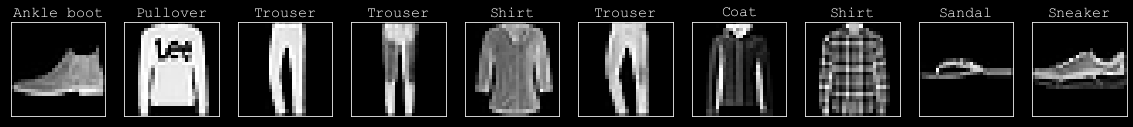

In [64]:
print("The train set contains {} images, in {} batches".format(len(train_loader.dataset), len(train_loader)))
print("The validation set contains {} images, in {} batches".format(len(valid_loader.dataset), len(valid_loader)))
print("The test set contains {} images, in {} batches".format(len(test_loader.dataset), len(test_loader)))
nsamples = 10
classes_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal','Shirt', 'Sneaker', 'Bag', 'Ankle boot']
imgs_test, labels = next(iter(test_loader))
fig = plt.figure(figsize=(20,5))
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    plt.imshow(imgs_test[i, 0, :, :], vmin=0, vmax=1.0, cmap=matplotlib.cm.gray)
    ax.set_title("{}".format(classes_names[labels[i]]), fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [65]:
# Using Bernoulli or Multinomial loss
num_classes = 1
# Number of hidden and latent
n_hidden = 512
n_latent = 2
# Compute input dimensionality
nin = imgs_test.shape[2] * imgs_test.shape[3]
# Construct encoder and decoder
encoder, decoder = construct_encoder_decoder(nin, n_hidden = n_hidden, n_latent = n_latent, n_classes = num_classes)
# Build the VAE model
model = VAE(encoder, decoder, n_hidden, n_latent)
# Construct the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Epoch: 1, Test set ELBO: tensor([2980998.5000], grad_fn=<AddBackward0>)


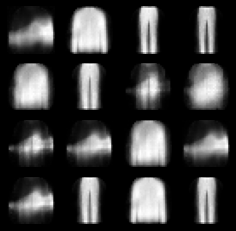

Epoch: 2, Test set ELBO: tensor([1557121.6250], grad_fn=<AddBackward0>)


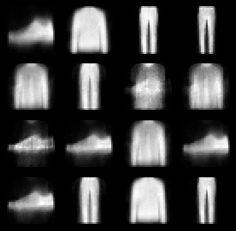

Epoch: 3, Test set ELBO: tensor([1420368.1250], grad_fn=<AddBackward0>)


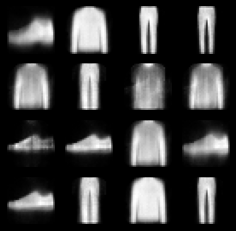

Epoch: 4, Test set ELBO: tensor([1347642.], grad_fn=<AddBackward0>)


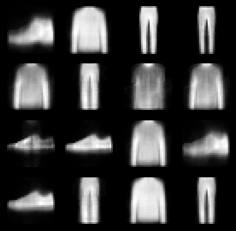

Epoch: 5, Test set ELBO: tensor([1305693.3750], grad_fn=<AddBackward0>)


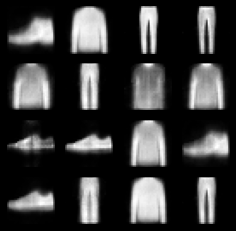

Epoch: 6, Test set ELBO: tensor([1276367.8750], grad_fn=<AddBackward0>)


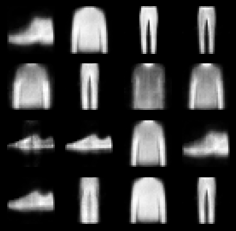

Epoch: 7, Test set ELBO: tensor([1252584.7500], grad_fn=<AddBackward0>)


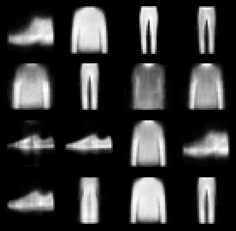

Epoch: 8, Test set ELBO: tensor([1231531.3750], grad_fn=<AddBackward0>)


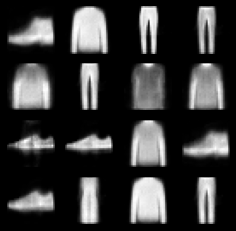

Epoch: 9, Test set ELBO: tensor([1211362.], grad_fn=<AddBackward0>)


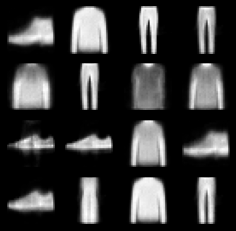

Epoch: 10, Test set ELBO: tensor([1193420.7500], grad_fn=<AddBackward0>)


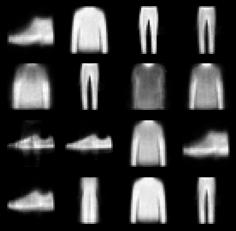

Epoch: 11, Test set ELBO: tensor([1177524.5000], grad_fn=<AddBackward0>)


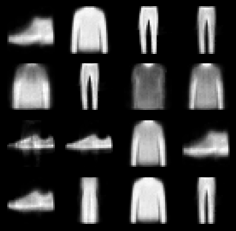

Epoch: 12, Test set ELBO: tensor([1163021.7500], grad_fn=<AddBackward0>)


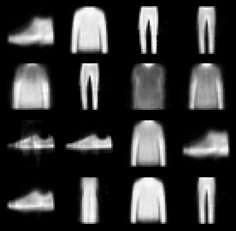

Epoch: 13, Test set ELBO: tensor([1150593.8750], grad_fn=<AddBackward0>)


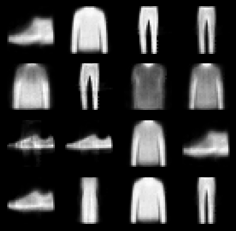

Epoch: 14, Test set ELBO: tensor([1137115.5000], grad_fn=<AddBackward0>)


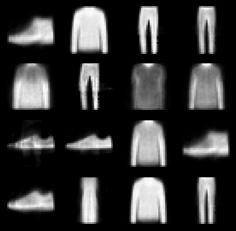

Epoch: 15, Test set ELBO: tensor([1124747.8750], grad_fn=<AddBackward0>)


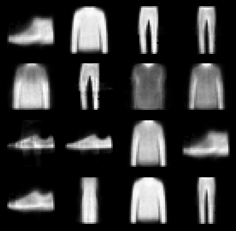

Epoch: 16, Test set ELBO: tensor([1113466.6250], grad_fn=<AddBackward0>)


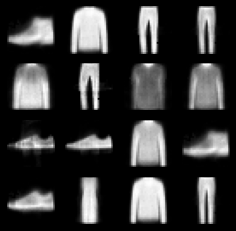

Epoch: 17, Test set ELBO: tensor([1104234.2500], grad_fn=<AddBackward0>)


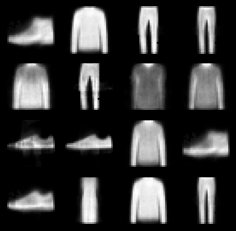

Epoch: 18, Test set ELBO: tensor([1095258.3750], grad_fn=<AddBackward0>)


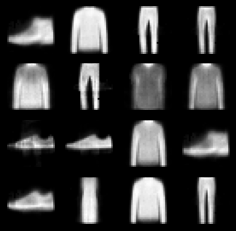

Epoch: 19, Test set ELBO: tensor([1086197.7500], grad_fn=<AddBackward0>)


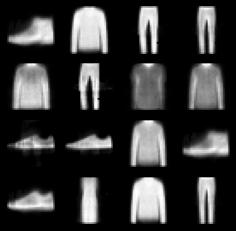

Epoch: 20, Test set ELBO: tensor([1079562.1250], grad_fn=<AddBackward0>)


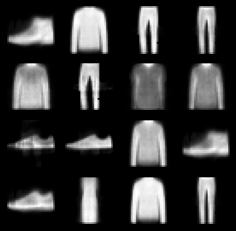

In [66]:

def generate_and_save_images(model, epoch, test_sample):
    predictions, _ = model(test_sample)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, 0, :, :].detach(), cmap='gray')
        plt.axis('off')
    # Tight_layout minimizes the overlap between 2 sub-plots
    #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

epochs=20
test_sample = imgs_test[0:16, :, :, :]
for epoch in range(1, epochs + 1):
    full_loss = torch.Tensor([0])
    # Forward pass: compute predicted y by passing x to the model.
    for i, (x, _) in enumerate(train_loader):
        full_loss += train_step(model, x, optimizer)
    #for i, (x, _) in enumerate(valid_loader):
    #    train_step(model, x, optimizer)
    print('Epoch: {}, Test set ELBO: {}'.format(epoch, full_loss))
    generate_and_save_images(model, epoch, test_sample)

### Evaluating generative models

computation of the Negative Log-Likelihood. This code for the following `evaluate_nll_bpd` is inspired by the [Sylvester flow repository](https://github.com/riannevdberg/sylvester-flows)

In [41]:
from scipy.special import logsumexp

def evaluate_nll_bpd(data_loader, model, batch = 500, R = 5):
    # Set of likelihood tests
    likelihood_test = []
    # Go through dataset
    for batch_idx, (x, _) in enumerate(data_loader):
        for j in range(x.shape[0]):
            a = []
            for r in range(0, R):
                cur_x = x[j].unsqueeze(0)
                # Repeat it as batch
                x = cur_x.expand(batch, *cur_x.size()[1:]).contiguous()
                x = x.view(batch, -1)
                x_tilde, kl_div = model(x)
                rec = reconstruction_loss(x_tilde, x, average=False)
                a_tmp = (rec + kl_div)
                a.append(- a_tmp.cpu().data.numpy())
            # calculate max
            a = np.asarray(a)
            a = np.reshape(a, (a.shape[0] * a.shape[1], 1))
            likelihood_x = logsumexp(a)
            likelihood_test.append(likelihood_x - np.log(len(a)))
    likelihood_test = np.array(likelihood_test)
    nll = - np.mean(likelihood_test)
    # Compute the bits per dim (but irrelevant for binary data)
    bpd = nll / (np.prod(nin) * np.log(2.))
    return nll, bpd

Now we can evaluate our VAE model more formally as follows.

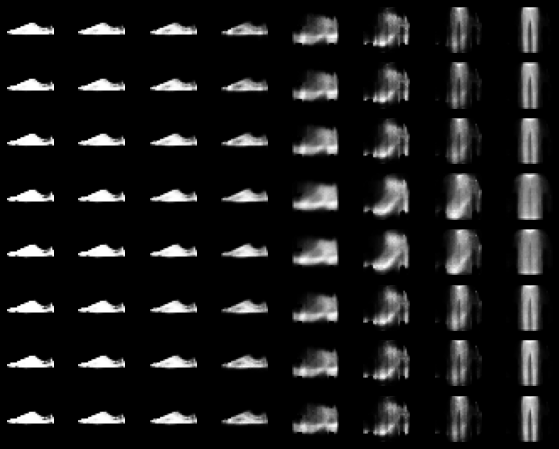

In [43]:
x = np.linspace(-3, 3, 8)
y = np.linspace(-3, 3, 8)
fig = plt.figure(figsize=(10, 8))
for i in range(8):
    for j in range(8):
        plt.subplot(8, 8, (i * 8) + j + 1)
        final_tensor = torch.zeros(2)
        final_tensor[0] = x[i]
        final_tensor[1] = y[j]
        plt.imshow(model.decode(final_tensor).detach().reshape(28, 28), cmap='gray')
        plt.axis('off')